# 1.1. Convolution

Convolution is a ubiquitous operation in deep networks, therefore the popular term convolutional neural networks (CNN). This notebook provides a short introduction to convolution.

Convolution is the process of adding each element of the signal (e.g., image) to its local neighbours, weighted by the kernel. A kernel defines the dimension of a window that is slid across all elements of the input, therefore the convolution of a signal with a kernel is referred to as **sliding window** operation. 

<img src="https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif" >

Convolution is a popular operation in signal processing (e.g., classical image processing algorithms), and therefore its implemented in several libraries. We explore a few of those implementations in this notebook.


## 0. Preparation
### Packages

Let's start with all the necessary packages to implement this tutorial.

 * [numpy](https://numpy.org/) is the main package for scientific computing with Python. It's often imported with the `np` shortcut.
 * [matplotlib](https://matplotlib.org/) is a library to plot graphs in Python.
 * [torch](https://pytorch.org/docs/stable/index.html) is a deep learning framework that allows us to define networks, handle datasets, optimise a loss function, etc.
* [cv2](https://docs.opencv.org/4.x/index.html) is a leading computer vision library.
* [skimage](https://scikit-image.org/) is a collection of image processing algorithms.

In [1]:
# importing the necessary packages/libraries
import numpy as np
from matplotlib import pyplot as plt
import cv2
import skimage
import torch

### Input image

In our example, we work with images to see the effect of convolution on them. First, we read 
two images by their URL using the `skimage.io.imread` function. Next, we visualise the images
using `matplotlibt` routines.


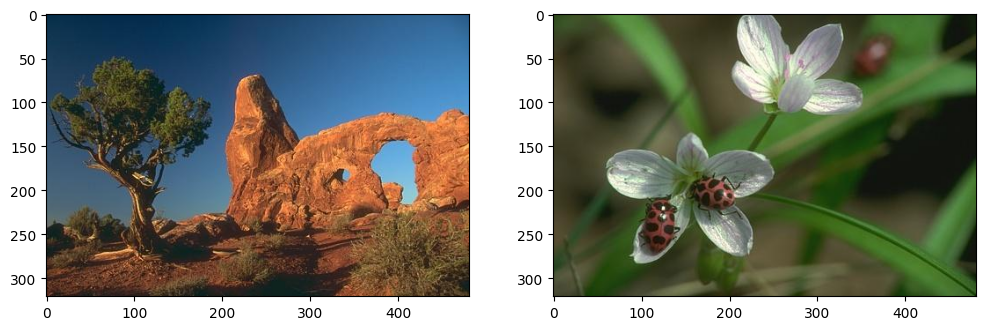

In [2]:
urls = [
    'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/295087.jpg',
    'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/35008.jpg'
]

# we use list comprehensions to quickly load images
imgs = [skimage.io.imread(url) for url in urls]

# visualising both images we loaded
fig = plt.figure(figsize=(12, 4))
for img_ind, img in enumerate(imgs):
    ax = fig.add_subplot(1, 2, img_ind + 1)
    ax.imshow(img)

An RGB image has the size ```(w, h, 3)```, and the third dimension corresponds to RGB (colour) channels). A grey-scale image has the size ```(w, h)```.

In [3]:
print("Image size:", imgs[0].shape)
print("Image type:", imgs[0].dtype)

Image size: (321, 481, 3)
Image type: uint8


Plotting each RGB channel separately. We define a function so we can call it for each image easily.

We use the ```pyplot``` (plt) to create a figure and add three subplots to it.

In [4]:
def plot_3channels(img):
    channel_names = ['Red', 'Green', 'Blue']
    fig = plt.figure(figsize=(16, 4))
    for i in range(img.shape[2]):
        ax = fig.add_subplot(1, 3, i+1)
        ax.imshow(img[..., i], cmap='gray')
        ax.axis('off')
        ax.set_title(channel_names[i])

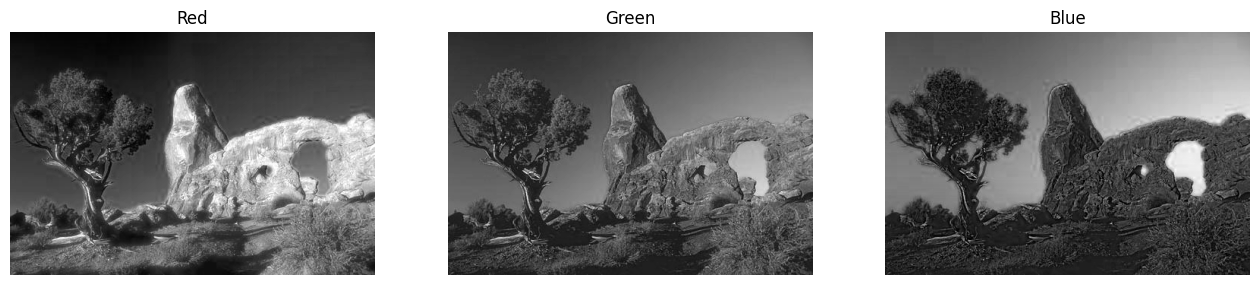

In [10]:
plot_3channels(imgs[0])

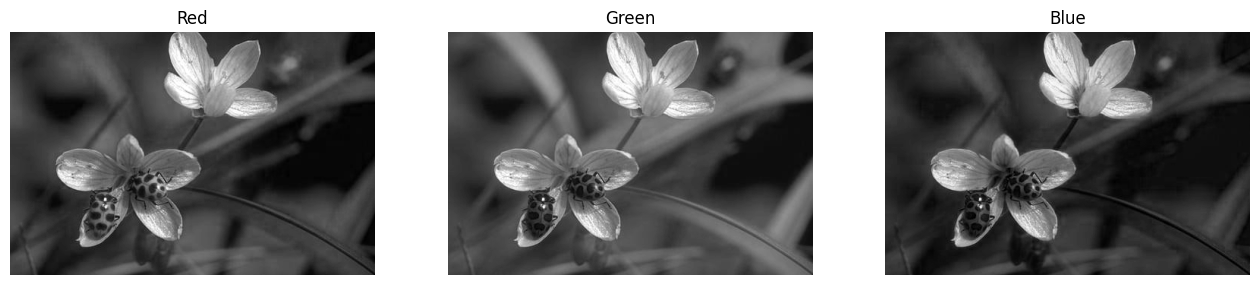

In [5]:
plot_3channels(imgs[1])

## 1. Open-CV

We use the `filter2D` function of the OpenCV (`cv2`) that implements the convolution.

### Edge detection
First, we design a simple edge kernel sensitive to vertical edges.

In [6]:
edge_kernel = np.array(
    [
        [1, 0, -1],
        [1, 0, -1],
        [1, 0, -1],
    ]
)
print(edge_kernel)

[[ 1  0 -1]
 [ 1  0 -1]
 [ 1  0 -1]]


In [7]:
edge_imgs = [cv2.filter2D(img.copy(), ddepth=-1, kernel=edge_kernel) for img in imgs]

Showing the obtained edges. The output might appear visually distorted because the edges in all RGB channels might not coincide.

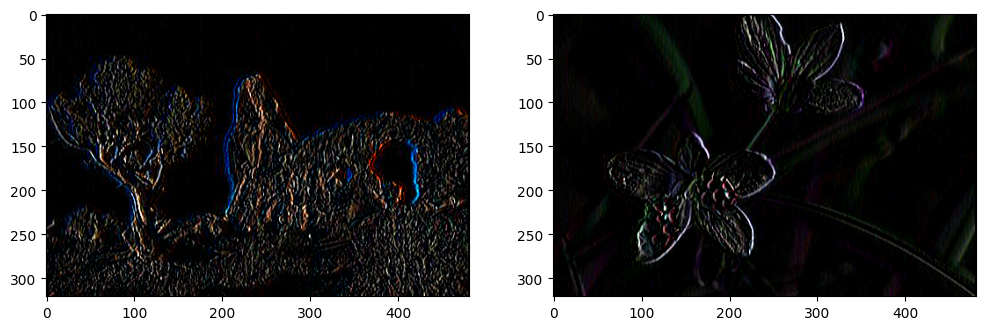

In [8]:
# visualising both images we loaded
fig = plt.figure(figsize=(12, 4))
for img_ind, img in enumerate(edge_imgs):
    ax = fig.add_subplot(1, 2, img_ind + 1)
    ax.imshow(img)

We can show the edges at each channel separately.

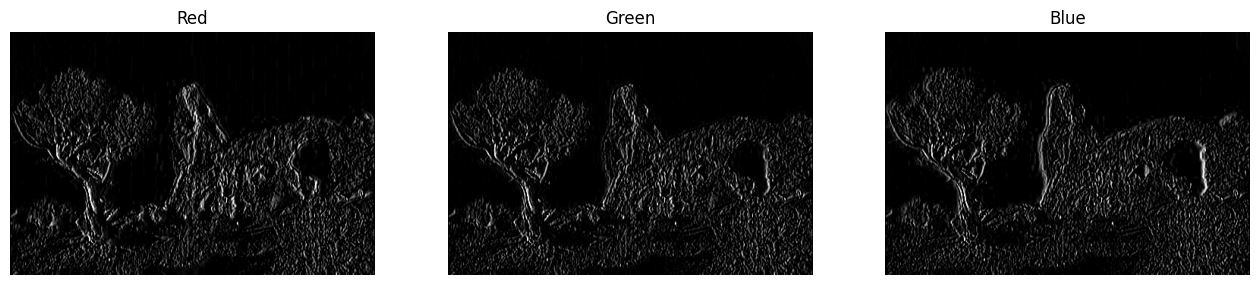

In [9]:
plot_3channels(edge_imgs[0])

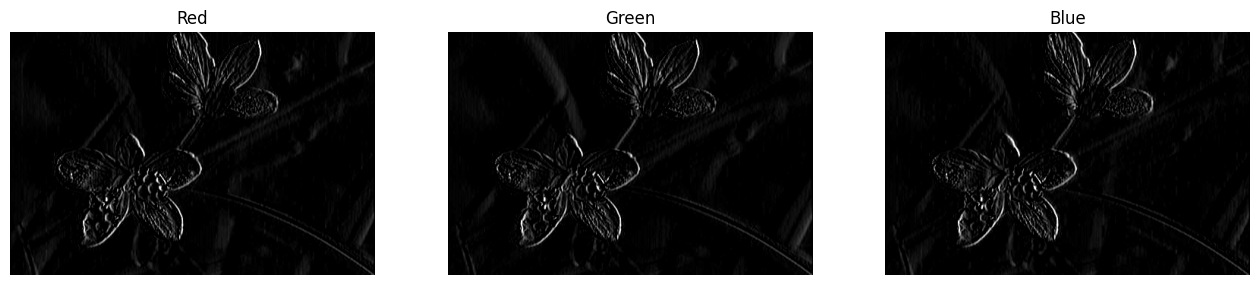

In [10]:
plot_3channels(edge_imgs[1])

**Question**: play with different kernel sizes (instead of current 3x3), what is the effect of larger kernel size?

### Image blurring
We define a kernel whose output is the average of the window.

In [11]:
kernel_size = 5
avg_kernel = np.ones((kernel_size, kernel_size)) / (kernel_size ** 2)
print(avg_kernel)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


In [12]:
blurred_imgs = [cv2.filter2D(img.copy(), ddepth=-1, kernel=avg_kernel) for img in imgs]

Showing the blurred images.

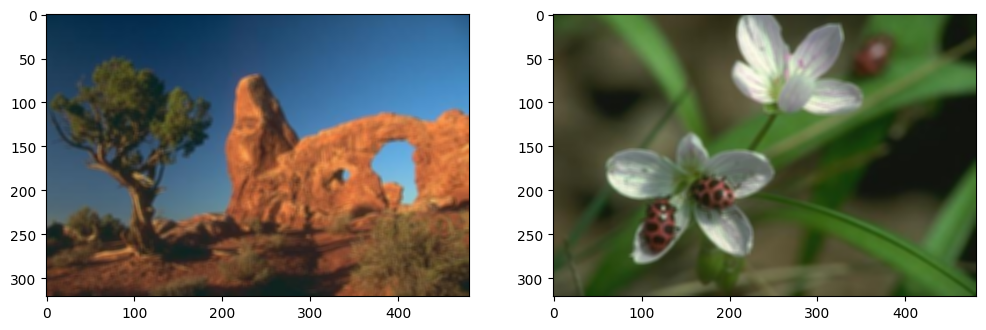

In [13]:
# visualising both images we loaded
fig = plt.figure(figsize=(12, 4))
for img_ind, img in enumerate(blurred_imgs):
    ax = fig.add_subplot(1, 2, img_ind + 1)
    ax.imshow(img)

## 2. PyTorch
Now we check similar operations in ```torch```. Note, torch functions are designed to be integrated into a network, but we use them here on single images to learn better basic operations.

### Tensor
In this tutorial, we'll use ```torch``` as one of the frameworks that implement convolution.

```torch``` expects images in a different format, the type should be ```float``` and channels should proceed the spatial dimension, i.e., ```(3, w, h)```.

Furthermore, ```torch``` functions are designed for Tensors of 4D, where the first dimension corresponds to different images ```(b, 3, w, h)```. In our example, b equals 2 as we have loaded two images.

In [14]:
# converting the images from uint8 to float and create a torch tensor
torch_tensors = [torch.from_numpy(img.astype('float32')) / 255 for img in imgs]
# permuting the tensor to place the RGB channles as the first dimension
torch_tensors = [torch.permute(torch_tensor, (2, 0, 1)) for torch_tensor in torch_tensors]
# stacking both images into one 4D tensor
torch_tensors = torch.stack(torch_tensors, dim=0)
print("Tensor size:", torch_tensors.shape)

Tensor size: torch.Size([2, 3, 321, 481])


### Edge detection

We use the ```torch.nn.Conv2d``` function to convolve a tensor with a kernel. Please note at this stage we only have defined the convolution function that we call a few lines below.

We set ```requires_grad``` to ```False``` as we don't want to update the parameters.

After printing the ```weights``` of the kernel, we see that they are from a random distribution.

```torch_conv.weight.shape``` returns a 4D shape, (1, 3, 3, 3) corresponding to (out_channels, in_channels, kernel_size, kernel_size).

In [16]:
torch_conv = torch.nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(3, 3), bias=False)
torch_conv.weight.requires_grad = False
print(torch_conv.weight)
print(torch_conv.weight.shape)

Parameter containing:
tensor([[[[ 0.1333, -0.0069,  0.0270],
          [ 0.0636, -0.0737, -0.0363],
          [ 0.0291, -0.0627,  0.1502]],

         [[ 0.1045,  0.1899, -0.1410],
          [ 0.0315, -0.1463, -0.0082],
          [-0.1500,  0.1781,  0.1124]],

         [[-0.1232,  0.1289,  0.1335],
          [-0.1755,  0.0696,  0.0701],
          [-0.0548,  0.0966, -0.1682]]]])
torch.Size([1, 3, 3, 3])


We fill in the weights with the edge kernel we defined earlier.

In [17]:
torch_conv.weight[0] = torch.from_numpy(np.stack([edge_kernel] * 3))
print(torch_conv.weight)

Parameter containing:
tensor([[[[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]],

         [[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]],

         [[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]]]])


We call the ```torch_conv``` function we defined to obtain edges in the torch.

The output size is ```(2, 1, W, H)```:
* 2 corresponds to two input images,
* 1 corresponds to the number of output channels.

**Question** Why is the output's width and height smaller than the input's dimensions which were $321 \times 481$?

In [18]:
torch_edges = torch_conv(torch_tensors)
print(torch_edges.shape)

torch.Size([2, 1, 319, 479])


Converting the torch outputs to numpy for visualisation.

**Question** Why do the results look quite different from what we obtained from open-cv?

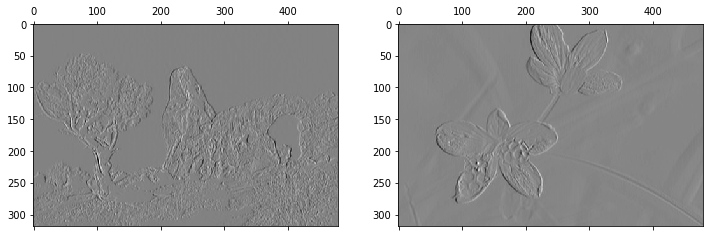

In [19]:
torch_edges_np = torch_edges.numpy()
torch_edges_np = np.transpose(torch_edges_np, (0, 2, 3, 1))

# visualising both images we loaded
fig = plt.figure(figsize=(12, 4))
for img_ind, img in enumerate(torch_edges_np):
    ax = fig.add_subplot(1, 2, img_ind + 1)
    ax.matshow(img, cmap='gray')

## 3. Kernel size

Kernels often have a window of an odd size to facilitate the centring of the kernel on top of each pixel.
The size of the kernel at each dimension can be specified accordingly by passing a `tuple` to the `kernel_size` argument. For instance:
* `kernel_size=(3, 3)` defines a square window.
* `kernel_size=(11, 3)` has a window spanning over 11 rows and 3 columns.
* `kernel_size=(5, 1)` performs convolution only over rows.

### $1 \times 1$ convolution

A $1 \times 1$ convolution ignores the spatial resolution and only convolves over the depth of
the input signal. This is a very useful convolution to expand/shrink the number of channels/kernels
without affecting the spatial resolution.

## 4. Padding

Computing convolution for border pixels is not possible without padding. Remember convolution 
is computed by overlaying the centre of the kernel on top of each pixel. This causes an issue for
border pixels because part of the kernels goes beyond the spatial resolution of the input image.
To avoid this issue we can pad the image using different values:
* 'constant'
* 'reflect'
* 'replicate'
* 'circular'.

If we want to have an output with the same spatial resolution as the input, we should pad the image
with $\frac{kernel\_size}{2} - 1$. For instance, for our example with `kernel_size=(3, 3)`, we
add `padding=1`.

In [25]:
torch_conv = torch.nn.Conv2d(
    in_channels=3, out_channels=1, kernel_size=(3, 3), bias=False, padding=1
)
torch_edges = torch_conv(torch_tensors)
print(torch_edges.shape)

torch.Size([2, 1, 321, 481])


## 5. Downsampling

One way to gradually downsample the input signal is to perform convolution without padding
which reduces the spatial resolution by $\frac{kernel\_size}{2} + 1$ as we saw in our example
without padding.

### Stride

In the convolution operation, we can systematically skip input pixels (e.g., every other one) to
downsample the input. This is used in several seminal architectures such as `ResNet`.

Similar to kernel size the value of stride (jumping pixels) can be defined
for each dimension independently.

If we perform convolution with `stride=2`, we downsample the spatial resolution by a factor of
two at both dimensions.

In [28]:
torch_conv = torch.nn.Conv2d(
    in_channels=3, out_channels=1, kernel_size=(3, 3), bias=False, padding=1, stride=2
)
out_conv = torch_conv(torch_tensors)
print(out_conv.shape)

torch.Size([2, 1, 161, 241])


Let's downsample only the rows by specifying `stride=(2, 1)`:

In [29]:
torch_conv = torch.nn.Conv2d(
    in_channels=3, out_channels=1, kernel_size=(3, 3), bias=False, padding=1, stride=(2, 1)
)
out_conv = torch_conv(torch_tensors)
print(out_conv.shape)

torch.Size([2, 1, 161, 481])


***
## Exercises
Below is a list of exercises helping you to practice what we learnt above.
1. Implement the image deblurring in the `torch`.
2. Convert a colourful image to grey scale using a convolution with `kernel_size=(1, 1)`.

***
## References

1. [Wikipedia Kernel (image processing)](https://en.wikipedia.org/wiki/Kernel_(image_processing))